# LangChain Retriever Benchmark: Financial QA Evaluation

## Overview

This notebook compares **five advanced LangChain retrievers** on a financial Q&A dataset using rigorous information retrieval metrics.

**Goal**: Understand which retriever architectures excel at finding the right context for financial questions across different recall depths (k=1, 3, 5).

**Retrievers Compared**:
1. **Base Dense Retriever** — vanilla similarity search
2. **Parent Document Retriever** — chunk-to-parent aggregation for context
3. **MMR Retriever** — diversity via Maximal Marginal Relevance
4. **Self-Query Retriever** — LLM-powered metadata filtering
5. **Multi-Query Retriever** — query expansion with paraphrases

**Evaluation Metrics**: Recall@k, Precision@k, MRR@k, nDCG@k with bootstrap 95% confidence intervals.


## 0. Setup and Imports

Import all necessary libraries and load configuration settings for reproducibility.


In [1]:
# Core libraries
import json
import hashlib
import os
import sys
import warnings
import random
from pathlib import Path
from typing import List, Dict, Any, Tuple
from collections import defaultdict

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# LangChain core
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS, Chroma
from langchain_classic.storage import InMemoryStore
from langchain_classic.retrievers import ParentDocumentRetriever
from langchain_classic.retrievers.multi_query import MultiQueryRetriever
from langchain_classic.retrievers.self_query.base import SelfQueryRetriever
from langchain_classic.chains.query_constructor.base import AttributeInfo
from langchain_core.prompts import PromptTemplate
from langchain_community.llms import Ollama

# Suppress warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')
import config

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ All imports successful!")
print(f"📍 Python version: {sys.version.split()[0]}")
print(f"📍 NumPy version: {np.__version__}")
print(f"📍 Pandas version: {pd.__version__}")


✅ All imports successful!
📍 Python version: 3.11.13
📍 NumPy version: 2.3.3
📍 Pandas version: 2.3.2


### Configuration Settings

Load settings from config.py and define evaluation parameters for consistency across all retrievers.


In [2]:
# Configuration parameters
EMBEDDING_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LLM_NAME = "qwen3:8b"  # Ollama model for Self-Query and Multi-Query
CHUNK_SIZE = 200
CHUNK_OVERLAP = 50
PARENT_CHUNK_SIZE = 500
PARENT_CHUNK_OVERLAP = 200

# K values for different retrievers
K_BASE = 5  # Base Dense retriever
K_PARENT = 5  # Parent Document retriever
K_MMR = 5  # MMR retriever

MMR_DIVERSITY_LAMBDA = 0.5  # Balance between relevance and diversity
MULTI_QUERY_N = 3  # Number of query paraphrases
N_BOOTSTRAP = 1000  # Bootstrap resamples for confidence intervals

# Paths
DATA_PATH = Path(config.DATA_DIR) / "financial_qa.jsonl"
ARTIFACTS_DIR = Path(config.PROJECT_ROOT) / "artifacts"
PLOTS_DIR = ARTIFACTS_DIR / "plots"
# EMBEDDINGS_CACHE = ARTIFACTS_DIR / "embeddings_cache.pkl"

# Create directories
ARTIFACTS_DIR.mkdir(exist_ok=True)
PLOTS_DIR.mkdir(exist_ok=True)

print(f"📊 Evaluation @ k: Base={K_BASE}, Parent={K_PARENT}, MMR={K_MMR}")
print(f"🎲 Random seed: {SEED}")
print(f"🔢 Bootstrap samples: {N_BOOTSTRAP}")


📊 Evaluation @ k: Base=5, Parent=5, MMR=5
🎲 Random seed: 42
🔢 Bootstrap samples: 1000


### Initialize Embedding Model

Set up the HuggingFace embedding model for document vectorization across all retrievers.


In [3]:
# Initialize embedding model
print("🔤 Initializing embedding model...")
embeddings = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL,
    model_kwargs={'device': config.DEVICE},
)
print(f"✅ Embedding model ready: {EMBEDDING_MODEL}")

# Initialize LLM for Self-Query and Multi-Query retrievers
print("🤖 Initializing LLM...")
llm = Ollama(model=LLM_NAME, temperature=0.0)
print(f"✅ LLM ready: {LLM_NAME}")


🔤 Initializing embedding model...
✅ Embedding model ready: sentence-transformers/all-MiniLM-L6-v2
🤖 Initializing LLM...
✅ LLM ready: qwen3:8b


## 1. Load Dataset

Load the financial QA dataset and validate its schema for evaluation.


### Sample Subset for Faster Evaluation

**Why sampling 300 records:**
1. Full dataset has 7,000 Q&A pairs - too large for quick iteration
2. **300 samples** provide statistically meaningful evaluation while being computationally efficient
3. Random shuffling ensures representative coverage across companies, tickers, and filing types
4. Faster vector store creation and retrieval evaluation for prototyping


In [4]:
# Load financial QA dataset
financial_qa = []
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        financial_qa.append(json.loads(line))

print(f"✅ Loaded {len(financial_qa)} question-answer pairs")

# Sample 300 records randomly
# SAMPLE_SIZE = 300
# print(f"\n🎲 Sampling {SAMPLE_SIZE} records (shuffled)...")
# random.seed(SEED)
# financial_qa = random.sample(financial_qa_full, SAMPLE_SIZE)
# print(f"✅ Selected {len(financial_qa)} records for evaluation")

# Validate schema
sample = financial_qa[0]
required_fields = ['question', 'answer', 'context', 'ticker', 'filing', 'company_name']
assert all(field in sample for field in required_fields), f"Missing required fields in data"

print(f"\n📊 Sample record:")
print(f"  Question: {sample['question'][:80]}...")
print(f"  Answer: {sample['answer'][:80]}...")
print(f"  Context: {sample['context'][:80]}...")
print(f"  Metadata: {sample['ticker']}, {sample['filing']}, {sample['company_name']}")


✅ Loaded 7000 question-answer pairs

📊 Sample record:
  Question: What area did NVIDIA initially focus on before expanding to other computationall...
  Answer: NVIDIA initially focused on PC graphics....
  Context: Since our original focus on PC graphics, we have expanded to several other large...
  Metadata: NVDA, 2023_10K, NVIDIA


In [ ]:
len(financial_qa)

## 2. Preprocessing & Doc ID Creation

Create stable document IDs for each record to enable relevance judgments during evaluation.


In [5]:
def create_doc_id(record: Dict) -> str:
    """Create a stable document ID from record metadata."""
    key = f"{record['ticker']}_{record['filing']}_{record['company_name']}_{record['context']}"
    return hashlib.md5(key.encode()).hexdigest()[:16]

# Add doc_id to each record
print("🔑 Creating document IDs...")
for record in financial_qa:
    record['doc_id'] = create_doc_id(record)

print(f"✅ Created {len(set(r['doc_id'] for r in financial_qa))} unique document IDs")

# Build corpus: unique contexts with metadata
print("\n📚 Building corpus of unique contexts...")
corpus_map = {}
for record in financial_qa:
    doc_id = record['doc_id']
    if doc_id not in corpus_map:
        corpus_map[doc_id] = {
            'doc_id': doc_id,
            'context': record['context'],
            'ticker': record['ticker'],
            'filing': record['filing'],
            'company_name': record['company_name']
        }

corpus = list(corpus_map.values())
print(f"✅ Corpus contains {len(corpus)} unique context documents")
print(f"📊 Total Q-A pairs: {len(financial_qa)}")
print(f"📊 Avg Q-A pairs per document: {len(financial_qa) / len(corpus):.2f}")


🔑 Creating document IDs...
✅ Created 6761 unique document IDs

📚 Building corpus of unique contexts...
✅ Corpus contains 6761 unique context documents
📊 Total Q-A pairs: 7000
📊 Avg Q-A pairs per document: 1.04


In [ ]:

# def rewrite_question(question: str, llm) -> str:
#     """Rewrite the question to be more specific and clear."""
#     prompt= f"""You are given a question from the user and you need to rewrite the question that gives the same meaning and outcome
#     but you must change the the words. try not to use the main questions words. 
#     question :
#     {question}
#     rewrite the question:
#     """
    
#     return llm.invoke(prompt)


# # Rewrite all questions BEFORE evaluation
# print("🔄 Rewriting questions using LLM...")
# print(f"   This will call LLM {len(financial_qa)} times")

# for idx, record in enumerate(financial_qa):
#     try:
#         rewritten = rewrite_question(record['question'], llm)
#         record['question_rewritten'] = rewritten
#     except Exception as e:
#         print(f"  ⚠️ Error rewriting Q{idx}: {e}")
#         # Fallback to original question if rewriting fails
#         record['question_rewritten'] = record['question']
    
#     # Progress indicator
#     if (idx + 1) % 50 == 0:
#         print(f"  Progress: {idx + 1}/{len(financial_qa)} questions rewritten")

# print(f"✅ All questions rewritten!")
# print(f"\n📊 Sample comparison:")
# sample = financial_qa[0]
# print(f"  Original:  {sample['question'][:100]}...")
# print(f"  Rewritten: {sample['question_rewritten'][:100]}...")


# import json
# from pathlib import Path

# # Save the updated financial_qa with rewritten questions
# output_path = Path(config.DATA_DIR) / "financial_qa_rewritten.jsonl"

# print(f"💾 Saving financial_qa with rewritten questions to {output_path}...")

# with open(output_path, 'w', encoding='utf-8') as f:
#     for record in financial_qa:
#         json.dump(record, f, ensure_ascii=False)
#         f.write('\n')

# print(f"✅ Saved {len(financial_qa)} records to {output_path}")

## 3. Text Splitting & Chunking

Split documents into chunks with metadata propagation for retrieval and relevance tracking.


In [6]:
# Create text splitters
print("✂️ Setting up text splitters...")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
)

parent_splitter = RecursiveCharacterTextSplitter(
    chunk_size=PARENT_CHUNK_SIZE,
    chunk_overlap=PARENT_CHUNK_OVERLAP,
    length_function=len,
)

# Create LangChain Documents from corpus
print("📝 Creating LangChain Documents...")
documents = []
for doc in corpus:
    documents.append(Document(
        page_content=doc['context'],
        metadata={
            'doc_id': doc['doc_id'],
            'ticker': doc['ticker'],
            'filing': doc['filing'],
            'company_name': doc['company_name']
        }
    ))

# Create child chunks (for base, MMR, self-query, multi-query retrievers)
print("✂️ Creating child chunks...")
child_chunks = text_splitter.split_documents(documents)
print(f"✅ Created {len(child_chunks)} child chunks from {len(documents)} documents")

print(f"\n📊 Chunking statistics:")
print(f"  Child chunk size: {CHUNK_SIZE} chars")
print(f"  Parent chunk size: {PARENT_CHUNK_SIZE} chars")
print(f"  Avg child chunks per document: {len(child_chunks) / len(documents):.2f}")
print(f"  Note: Parent chunks will be created internally by ParentDocumentRetriever")


✂️ Setting up text splitters...
📝 Creating LangChain Documents...
✂️ Creating child chunks...
✅ Created 11133 child chunks from 6761 documents

📊 Chunking statistics:
  Child chunk size: 200 chars
  Parent chunk size: 500 chars
  Avg child chunks per document: 1.65
  Note: Parent chunks will be created internally by ParentDocumentRetriever


## 4. Build Vector Stores & Retrievers - Context

Create vector stores and configure five different retriever architectures for comparison.


### 4.1 Base Dense Retriever - Context

Vanilla similarity search on embeddings using Chroma—the baseline for comparison.


In [7]:
# Build Chroma index for base retriever
print("🗄️ Building Base Dense Retriever (Chroma) - Context-based...")
base_vectorstore = Chroma.from_documents(
    documents=child_chunks,
    embedding=embeddings,
    collection_name="financial_qa_base"
)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": K_BASE})
print(f"✅ Base retriever ready with {len(child_chunks)} chunks indexed (k={K_BASE})")


🗄️ Building Base Dense Retriever (Chroma) - Context-based...
✅ Base retriever ready with 11133 chunks indexed (k=5)


### 4.2 Parent Document Retriever - Context

Search over small chunks, but return their larger parent documents for richer context.


In [8]:
# Build Parent Document Retriever
print("🗄️ Building Parent Document Retriever - Context-based...")

# Create EMPTY vectorstore (ParentDocumentRetriever will populate it)
parent_child_vectorstore = Chroma(
    collection_name="financial_qa_parent_child",
    embedding_function=embeddings
)

# Create empty parent document store
parent_docstore = InMemoryStore()

# Create retriever (it will handle parent-child relationships internally)
parent_retriever = ParentDocumentRetriever(
    vectorstore=parent_child_vectorstore,
    docstore=parent_docstore,
    child_splitter=text_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k": K_PARENT}
)

# Add documents in batches to avoid exceeding max batch size
print("   Adding documents to Parent Document Retriever in batches...")
BATCH_SIZE = 1000  # Process 1000 documents at a time
total_docs = len(documents)
for i in range(0, total_docs, BATCH_SIZE):
    batch = documents[i:i+BATCH_SIZE]
    parent_retriever.add_documents(batch)
    print(f"      Processed {min(i+BATCH_SIZE, total_docs)}/{total_docs} documents...")

print(f"✅ Parent Document retriever ready (k={K_PARENT})")
print(f"   Original documents: {len(documents)}")
print(f"   Parent-child relationships managed internally")


🗄️ Building Parent Document Retriever - Context-based...
   Adding documents to Parent Document Retriever in batches...
      Processed 1000/6761 documents...
      Processed 2000/6761 documents...
      Processed 3000/6761 documents...
      Processed 4000/6761 documents...
      Processed 5000/6761 documents...
      Processed 6000/6761 documents...
      Processed 6761/6761 documents...
✅ Parent Document retriever ready (k=5)
   Original documents: 6761
   Parent-child relationships managed internally


### 4.3 MMR Retriever - Context

Maximal Marginal Relevance balances similarity with diversity to avoid redundant results.


In [9]:
# Build MMR Retriever (uses same Chroma store as base)
print("🗄️ Building MMR Retriever - Context-based...")
mmr_retriever = base_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": K_MMR,
        "fetch_k": K_MMR * 4,  # Larger candidate pool
        "lambda_mult": MMR_DIVERSITY_LAMBDA  # 0 = max diversity, 1 = max relevance
    }
)
print(f"✅ MMR retriever ready (k={K_MMR})")
print(f"   λ (diversity): {MMR_DIVERSITY_LAMBDA}")
print(f"   fetch_k: {K_MMR * 4}")


🗄️ Building MMR Retriever - Context-based...
✅ MMR retriever ready (k=5)
   λ (diversity): 0.5
   fetch_k: 20


## 5. Build Vector Stores & Retrievers - Answers

Create the same three retriever architectures but using **answer embeddings** instead of context embeddings to compare performance.


### 4.1 Creating Document for Vector store



In [10]:
print("📚 Building answer-based documents...")

# Create answer documents using answers instead of contexts
answer_documents = []
for doc in corpus:
    # Find corresponding answer
    for record in financial_qa:
        if record['doc_id'] == doc['doc_id']:
            answer_documents.append(Document(
                page_content=record['answer'],
                metadata={
                    'doc_id': doc['doc_id'],
                    'ticker': doc['ticker'],
                    'filing': doc['filing'],
                    'company_name': doc['company_name']
                }
            ))
            break

print(f"✅ Created {len(answer_documents)} answer-based documents")

# Create child chunks from answers
print("✂️ Creating child chunks from answers...")
answer_child_chunks = text_splitter.split_documents(answer_documents)
print(f"✅ Created {len(answer_child_chunks)} answer chunks (avg: {len(answer_child_chunks) / len(answer_documents):.2f} per doc)")


📚 Building answer-based documents...
✅ Created 6761 answer-based documents
✂️ Creating child chunks from answers...
✅ Created 8669 answer chunks (avg: 1.28 per doc)


### 4.2 Base Dense Retriever - Answers


In [11]:
# Build Base Dense Retriever with Answer embeddings
print("🗄️ Building Base Dense Retriever (Answer-based)...")
answer_base_vectorstore = Chroma.from_documents(
    documents=answer_child_chunks,
    embedding=embeddings,
    collection_name="financial_qa_base_answer"
)
answer_base_retriever = answer_base_vectorstore.as_retriever(search_kwargs={"k": K_BASE})
print(f"✅ Answer-based Base retriever ready (k={K_BASE})")


🗄️ Building Base Dense Retriever (Answer-based)...
✅ Answer-based Base retriever ready (k=5)


### 4.2 Parent Document Retriever - Answers



In [13]:
# Build Parent Document Retriever with Answer embeddings
print("🗄️ Building Parent Document Retriever (Answer-based)...")

answer_parent_child_vectorstore = Chroma(
    collection_name="financial_qa_parent_child_answer",
    embedding_function=embeddings
)

answer_parent_docstore = InMemoryStore()

answer_parent_retriever = ParentDocumentRetriever(
    vectorstore=answer_parent_child_vectorstore,
    docstore=answer_parent_docstore,
    child_splitter=text_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k": K_PARENT}
)

print("   Adding answer documents to Parent Document Retriever in batches...")
BATCH_SIZE = 1000  # Process 1000 documents at a time
total_docs = len(answer_documents)
for i in range(0, total_docs, BATCH_SIZE):
    batch = answer_documents[i:i+BATCH_SIZE]
    answer_parent_retriever.add_documents(batch)
    print(f"      Processed {min(i+BATCH_SIZE, total_docs)}/{total_docs} documents...")

print(f"✅ Answer-based Parent Document retriever ready (k={K_PARENT})")


🗄️ Building Parent Document Retriever (Answer-based)...
   Adding answer documents to Parent Document Retriever in batches...
      Processed 1000/6761 documents...
      Processed 2000/6761 documents...
      Processed 3000/6761 documents...
      Processed 4000/6761 documents...
      Processed 5000/6761 documents...
      Processed 6000/6761 documents...
      Processed 6761/6761 documents...
✅ Answer-based Parent Document retriever ready (k=5)


### 4.2 MMR Retriever - Answers



In [12]:
# Build MMR Retriever with Answer embeddings
print("🗄️ Building MMR Retriever (Answer-based)...")
answer_mmr_retriever = answer_base_vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": K_MMR,
        "fetch_k": K_MMR * 4,
        "lambda_mult": MMR_DIVERSITY_LAMBDA
    }
)
print(f"✅ Answer-based MMR retriever ready (k={K_MMR})")
print(f"   λ (diversity): {MMR_DIVERSITY_LAMBDA}")
print(f"   fetch_k: {K_MMR * 4}")


🗄️ Building MMR Retriever (Answer-based)...
✅ Answer-based MMR retriever ready (k=5)
   λ (diversity): 0.5
   fetch_k: 20


In [14]:
# # Build Self-Query Retriever
# print("🗄️ Building Self-Query Retriever...")

# # Create Chroma vector store for Self-Query (FAISS not supported)
# print("   Creating Chroma vector store...")
# self_query_vectorstore = Chroma.from_documents(
#     documents=child_chunks,
#     embedding=embeddings,
#     collection_name="financial_qa_self_query"
# )

# # Define metadata fields for self-querying
# metadata_field_info = [
#     AttributeInfo(
#         name="ticker",
#         description="Stock ticker symbol (e.g., NVDA, AAPL, MSFT)",
#         type="string",
#     ),
#     AttributeInfo(
#         name="filing",
#         description="SEC filing type (e.g., 2023_10K, 2022_10K)",
#         type="string",
#     ),
#     AttributeInfo(
#         name="company_name",
#         description="Company name (e.g., NVIDIA, Apple, Microsoft)",
#         type="string",
#     ),
# ]

# document_content_description = "Financial question-answer context from 10-K filings"

# # Create self-query retriever
# try:
#     self_query_retriever = SelfQueryRetriever.from_llm(
#         llm=llm,
#         vectorstore=self_query_vectorstore,
#         document_contents=document_content_description,
#         metadata_field_info=metadata_field_info,
#         verbose=False,
#         search_kwargs={"k": max(TOPK_LIST)}
#     )
#     print(f"✅ Self-Query retriever ready with Chroma")
#     print(f"   Metadata filters: ticker, filing, company_name")
# except Exception as e:
#     print(f"⚠️ Self-Query retriever setup failed: {e}")
#     print(f"   Will fall back to base retriever for evaluation")
#     self_query_retriever = base_retriever  # Fallback


### 4.5 Multi-Query Retriever

Generates multiple paraphrases of the query using LLM, then retrieves and merges results from all variants.


In [15]:
# # Build Multi-Query Retriever
# print("🗄️ Building Multi-Query Retriever...")

# # Custom prompt for query generation
# multi_query_prompt = PromptTemplate(
#     input_variables=["question"],
#     template="""You are an AI assistant. Generate {n} different versions of the given financial question 
# to retrieve relevant documents from a vector database. Provide these alternative queries separated by newlines.
# Focus on preserving the core intent while varying the wording.

# Original question: {{question}}

# Alternative questions:""".replace("{n}", str(MULTI_QUERY_N))
# )

# # Create multi-query retriever
# try:
#     multi_query_retriever = MultiQueryRetriever.from_llm(
#         retriever=base_vectorstore.as_retriever(search_kwargs={"k": max(TOPK_LIST)}),
#         llm=llm,
#         prompt=multi_query_prompt
#     )
#     print(f"✅ Multi-Query retriever ready")
#     print(f"   Query expansions: {MULTI_QUERY_N}")
# except Exception as e:
#     print(f"⚠️ Multi-Query retriever setup failed: {e}")
#     print(f"   Will fall back to base retriever for evaluation")
#     multi_query_retriever = base_retriever  # Fallback


In [16]:
def extract_doc_id(doc: Document) -> str:
    """Extract doc_id from a retrieved document's metadata."""
    return doc.metadata.get('doc_id', '')

def is_relevant(retrieved_doc: Document, gold_doc_id: str, gold_context: str) -> bool:
    """Check if retrieved document is relevant to the question's gold context."""
    retrieved_doc_id = extract_doc_id(retrieved_doc)
    
    # Direct doc_id match
    if retrieved_doc_id == gold_doc_id:
        return True
    
    # Check if gold context is substring of retrieved content
    if gold_context in retrieved_doc.page_content:
        return True
    
    return False

def compute_recall_at_k(retrieved_docs: List[Document], gold_doc_id: str, gold_context: str, k: int) -> float:
    """Recall@k: Was the gold document retrieved in top-k?"""
    if k > len(retrieved_docs):
        k = len(retrieved_docs)
    
    for doc in retrieved_docs[:k]:
        if is_relevant(doc, gold_doc_id, gold_context):
            return 1.0
    return 0.0

def compute_precision_at_k(retrieved_docs: List[Document], gold_doc_id: str, gold_context: str, k: int) -> float:
    """Precision@k: Fraction of top-k that are relevant."""
    if k > len(retrieved_docs):
        k = len(retrieved_docs)
    if k == 0:
        return 0.0
    
    relevant_count = sum(
        1 for doc in retrieved_docs[:k] 
        if is_relevant(doc, gold_doc_id, gold_context)
    )
    return relevant_count / k

def compute_mrr_at_k(retrieved_docs: List[Document], gold_doc_id: str, gold_context: str, k: int) -> float:
    """MRR@k: 1/rank of first relevant doc in top-k, else 0."""
    if k > len(retrieved_docs):
        k = len(retrieved_docs)
    
    for rank, doc in enumerate(retrieved_docs[:k], start=1):
        if is_relevant(doc, gold_doc_id, gold_context):
            return 1.0 / rank
    return 0.0

# def compute_ndcg_at_k(retrieved_docs: List[Document], gold_doc_id: str, gold_context: str, k: int) -> float:
#     """nDCG@k: Normalized Discounted Cumulative Gain with binary relevance."""
#     if k > len(retrieved_docs):
#         k = len(retrieved_docs)
#     if k == 0:
#         return 0.0
    
#     # DCG: sum of rel_i / log2(i+1)
#     dcg = 0.0
#     for rank, doc in enumerate(retrieved_docs[:k], start=1):
#         relevance = 1.0 if is_relevant(doc, gold_doc_id, gold_context) else 0.0
#         dcg += relevance / np.log2(rank + 1)
    
#     # IDCG: ideal ranking (all relevant docs at top)
#     # In our case, there's typically 1 relevant doc, so IDCG = 1/log2(2) = 1.0
#     idcg = 1.0 / np.log2(2)  # Assuming 1 relevant doc
    
#     return dcg / idcg if idcg > 0 else 0.0

print("✅ Evaluation utility functions defined:")
print("   - is_relevant()")
print("   - compute_recall_at_k()")
print("   - compute_precision_at_k()")
print("   - compute_mrr_at_k()")
# print("   - compute_ndcg_at_k()")


✅ Evaluation utility functions defined:
   - is_relevant()
   - compute_recall_at_k()
   - compute_precision_at_k()
   - compute_mrr_at_k()


### Bootstrap Confidence Intervals

Compute 95% CIs via bootstrapping for robust uncertainty estimates across questions.


In [17]:
def bootstrap_ci(values: List[float], n_bootstrap: int = N_BOOTSTRAP, confidence: float = 0.95) -> Tuple[float, float, float]:
    """
    Compute mean and bootstrap confidence interval.
    
    Returns:
        (mean, ci_lower, ci_upper)
    """
    if len(values) == 0:
        return 0.0, 0.0, 0.0
    
    values_array = np.array(values)
    mean_val = np.mean(values_array)
    
    # Bootstrap resampling
    bootstrap_means = []
    rng = np.random.RandomState(SEED)
    
    for _ in range(n_bootstrap):
        sample = rng.choice(values_array, size=len(values_array), replace=True)
        bootstrap_means.append(np.mean(sample))
    
    # Compute confidence interval
    alpha = 1 - confidence
    ci_lower = np.percentile(bootstrap_means, alpha/2 * 100)
    ci_upper = np.percentile(bootstrap_means, (1 - alpha/2) * 100)
    
    return mean_val, ci_lower, ci_upper

print("✅ Bootstrap CI function defined")
print(f"   Resamples: {N_BOOTSTRAP}")
print(f"   Confidence level: 95%")


✅ Bootstrap CI function defined
   Resamples: 1000
   Confidence level: 95%


## 6. Run Evaluation

Evaluate all five retrievers across the financial QA dataset at k=1, 3, 5.


In [18]:
# Configure retrievers dictionary with their specific k values
retrievers = {
    "Base Dense (Context)": {"retriever": base_retriever, "k": K_BASE},
    "Parent Document (Context)": {"retriever": parent_retriever, "k": K_PARENT},
    "MMR (Context)": {"retriever": mmr_retriever, "k": K_MMR},
    "Base Dense (Answer)": {"retriever": answer_base_retriever, "k": K_BASE},
    "Parent Document (Answer)": {"retriever": answer_parent_retriever, "k": K_PARENT},
    "MMR (Answer)": {"retriever": answer_mmr_retriever, "k": K_MMR},
}

print("🔍 Configured retrievers for evaluation:")
print("Context-based:")
for name, config in list(retrievers.items())[:3]:
    print(f"   - {name} (k={config['k']})")
print("Answer-based:")
for name, config in list(retrievers.items())[3:]:
    print(f"   - {name} (k={config['k']})")
print(f"\n📊 Evaluation plan:")
print(f"   Total retrievers: {len(retrievers)}")
print(f"   Questions: {len(financial_qa)}")
print(f"   Metrics: Recall@k, Precision@k, MRR@k (nDCG removed)")


🔍 Configured retrievers for evaluation:
Context-based:
   - Base Dense (Context) (k=5)
   - Parent Document (Context) (k=5)
   - MMR (Context) (k=5)
Answer-based:
   - Base Dense (Answer) (k=5)
   - Parent Document (Answer) (k=5)
   - MMR (Answer) (k=5)

📊 Evaluation plan:
   Total retrievers: 6
   Questions: 7000
   Metrics: Recall@k, Precision@k, MRR@k (nDCG removed)


In [19]:
# Run evaluation across all retrievers and questions
print("🚀 Starting evaluation...")
print(f"{'='*70}")

# Store results: {retriever_name: {question_idx: {metric: value}}}
results = defaultdict(lambda: defaultdict(dict))

for retriever_name, config in retrievers.items():
    retriever = config['retriever']
    k = config['k']
    
    print(f"\n🔍 Evaluating {retriever_name} (k={k})...")
    
    for question_idx, record in enumerate(financial_qa):
        # Use original question
        question_to_use = record['question']
        gold_doc_id = record['doc_id']
        gold_context = record['context']
        
        # Retrieve documents
        try:
            retrieved_docs = retriever.invoke(question_to_use)
        except Exception as e:
            print(f"  ⚠️ Error retrieving for Q{question_idx}: {e}")
            retrieved_docs = []
        
        # Compute metrics at the specific k for this retriever (no nDCG)
        results[retriever_name][question_idx] = {
            'k': k,
            'recall': compute_recall_at_k(retrieved_docs, gold_doc_id, gold_context, k),
            'precision': compute_precision_at_k(retrieved_docs, gold_doc_id, gold_context, k),
            'mrr': compute_mrr_at_k(retrieved_docs, gold_doc_id, gold_context, k)
        }
        
        # Progress indicator
        if (question_idx + 1) % 1000 == 0:
            print(f"  Progress: {question_idx + 1}/{len(financial_qa)} questions")
    
    print(f"✅ {retriever_name} evaluation complete")

print(f"\n{'='*70}")
print("✅ All evaluations complete!")


🚀 Starting evaluation...

🔍 Evaluating Base Dense (Context) (k=5)...
  Progress: 1000/7000 questions
  Progress: 2000/7000 questions
  Progress: 3000/7000 questions
  Progress: 4000/7000 questions
  Progress: 5000/7000 questions
  Progress: 6000/7000 questions
  Progress: 7000/7000 questions
✅ Base Dense (Context) evaluation complete

🔍 Evaluating Parent Document (Context) (k=5)...
  Progress: 1000/7000 questions
  Progress: 2000/7000 questions
  Progress: 3000/7000 questions
  Progress: 4000/7000 questions
  Progress: 5000/7000 questions
  Progress: 6000/7000 questions
  Progress: 7000/7000 questions
✅ Parent Document (Context) evaluation complete

🔍 Evaluating MMR (Context) (k=5)...
  Progress: 1000/7000 questions
  Progress: 2000/7000 questions
  Progress: 3000/7000 questions
  Progress: 4000/7000 questions
  Progress: 5000/7000 questions
  Progress: 6000/7000 questions
  Progress: 7000/7000 questions
✅ MMR (Context) evaluation complete

🔍 Evaluating Base Dense (Answer) (k=5)...
  P

## 7. Aggregate Results & Compute Confidence Intervals

Compute mean metrics and bootstrap 95% CIs across all questions for each retriever and k value.


In [20]:
# Aggregate results into structured format
print("📊 Aggregating results...")

metrics_list = ['recall', 'precision', 'mrr']  # Removed nDCG
aggregated_data = []

for retriever_name in retrievers.keys():
    # Get k value for this retriever
    k = retrievers[retriever_name]['k']
    
    for metric in metrics_list:
        # Collect all values for this retriever/metric combination
        values = [
            results[retriever_name][q_idx][metric]
            for q_idx in range(len(financial_qa))
        ]
        
        # Compute mean and CI
        mean_val, ci_lower, ci_upper = bootstrap_ci(values)
        
        aggregated_data.append({
            'Retriever': retriever_name,
            'k': k,
            'Metric': f'{metric}@{k}',
            'Mean': mean_val,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper,
            'Std': np.std(values)
        })

# Create DataFrame
df_results = pd.DataFrame(aggregated_data)

print(f"✅ Aggregation complete")
print(f"   Total result rows: {len(df_results)}")
print(f"\n📊 Sample results:")
print(df_results.to_markdown())


📊 Aggregating results...
✅ Aggregation complete
   Total result rows: 18

📊 Sample results:
|    | Retriever                 |   k | Metric      |     Mean |   CI_Lower |   CI_Upper |       Std |
|---:|:--------------------------|----:|:------------|---------:|-----------:|-----------:|----------:|
|  0 | Base Dense (Context)      |   5 | recall@5    | 0.790714 |   0.780568 |   0.800714 | 0.406799  |
|  1 | Base Dense (Context)      |   5 | precision@5 | 0.1794   |   0.176629 |   0.182343 | 0.116833  |
|  2 | Base Dense (Context)      |   5 | mrr@5       | 0.683652 |   0.673676 |   0.693851 | 0.420682  |
|  3 | Parent Document (Context) |   5 | recall@5    | 0.791    |   0.780854 |   0.801    | 0.406594  |
|  4 | Parent Document (Context) |   5 | precision@5 | 0.173264 |   0.170733 |   0.175824 | 0.104721  |
|  5 | Parent Document (Context) |   5 | mrr@5       | 0.684455 |   0.674412 |   0.694289 | 0.420275  |
|  6 | MMR (Context)             |   5 | recall@5    | 0.722571 |   0.712286

In [22]:
# Save aggregated results to CSV
metrics_summary_path = ARTIFACTS_DIR / "metrics_summary.csv"
df_results.to_csv(metrics_summary_path, index=False)
print(f"💾 Saved metrics summary to: ARTIFACTS folder")

# Create per-question results DataFrame (for deeper analysis)
per_question_data = []
for retriever_name in retrievers.keys():
    k = retrievers[retriever_name]['k']
    for q_idx in range(len(financial_qa)):
        per_question_data.append({
            'retriever': retriever_name,
            'question_idx': q_idx,
            **results[retriever_name][q_idx]
        })

df_per_question = pd.DataFrame(per_question_data)
per_question_path = ARTIFACTS_DIR / "per_question_results.parquet"
df_per_question.to_parquet(per_question_path, index=False)
print(f"   Shape: {df_per_question.shape}")


💾 Saved metrics summary to: ARTIFACTS folder
   Shape: (42000, 6)


## 8. Visualizations

Create bar charts for each metric comparing all retrievers with 95% confidence intervals.


In [23]:
# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Color palette for retrievers
retriever_colors = {
    "Base Dense (Context)": "#1f77b4",
    "Parent Document (Context)": "#ff7f0e", 
    "MMR (Context)": "#2ca02c",
    "Base Dense (Answer)": "#8ecae6",
    "Parent Document (Answer)": "#ffb703",
    "MMR (Answer)": "#90ee90"
}

metrics = ['recall', 'precision', 'mrr']  # Removed nDCG

print("🎨 Plotting configuration ready")
print(f"   Metrics to plot: {metrics}")


🎨 Plotting configuration ready
   Metrics to plot: ['recall', 'precision', 'mrr']


💾 Saved recall plot to: ARTIFACTS folder


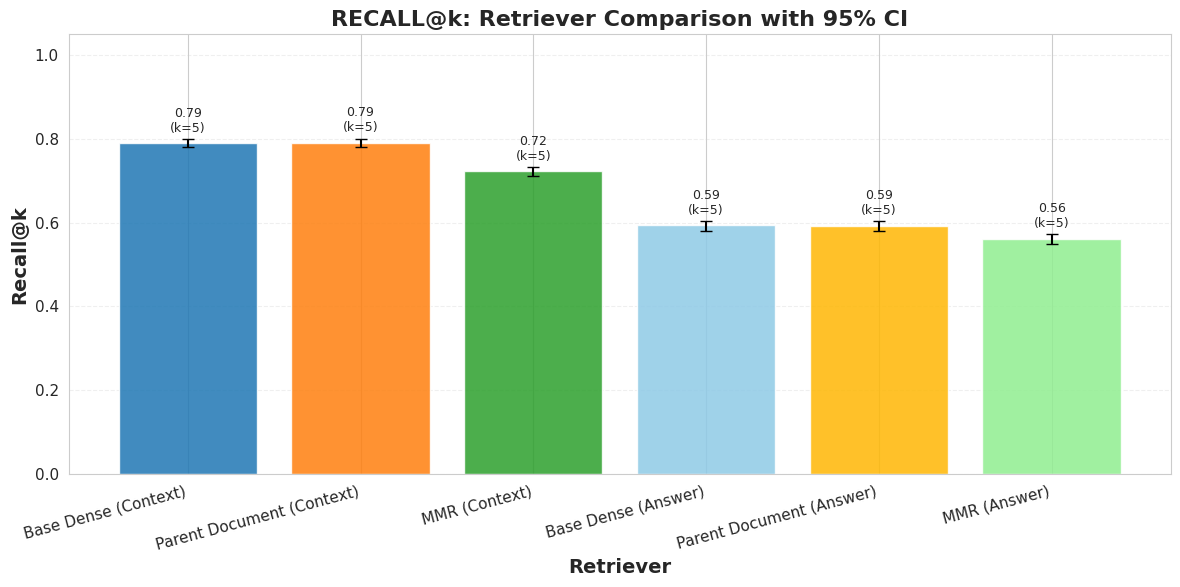

💾 Saved precision plot to: ARTIFACTS folder


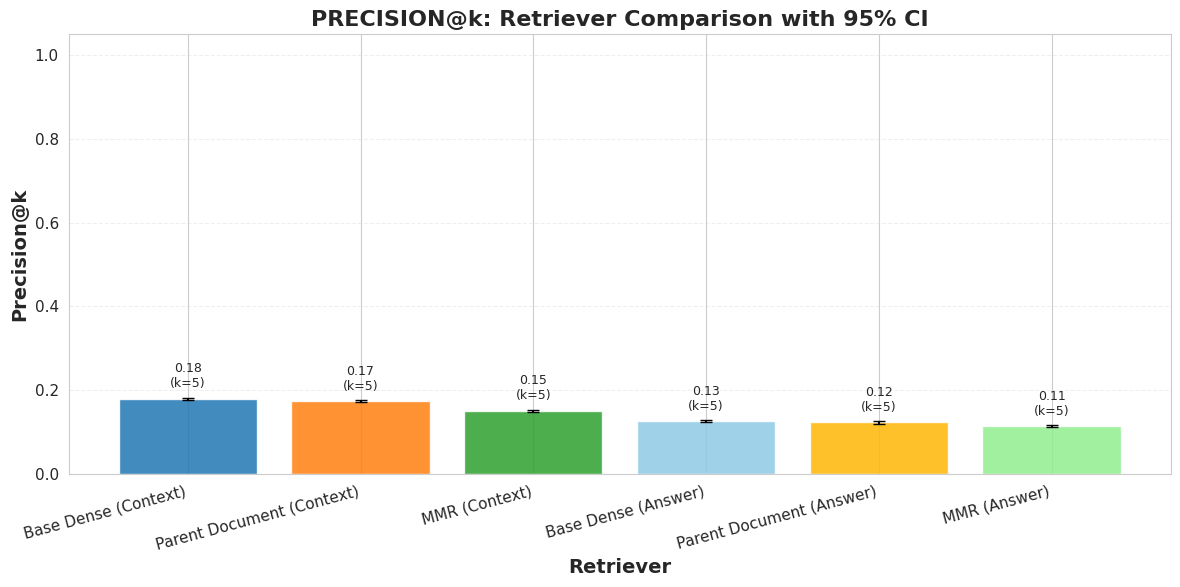

💾 Saved mrr plot to: ARTIFACTS folder


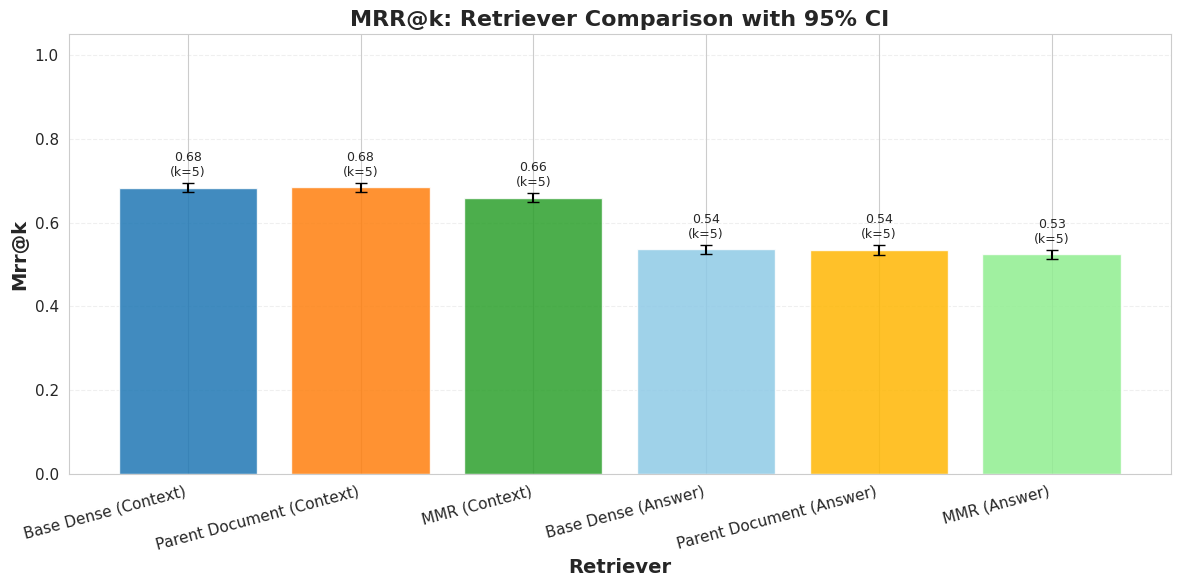


✅ Individual metric plots complete!


In [24]:
# Create individual plots for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Filter data for this metric
    metric_df = df_results[df_results['Metric'].str.startswith(metric)]
    
    # Create bar chart with retrievers on x-axis
    x = np.arange(len(retrievers))
    retriever_names = list(retrievers.keys())
    
    means = []
    ci_lowers = []
    ci_uppers = []
    colors = []
    
    for retriever_name in retriever_names:
        ret_data = metric_df[metric_df['Retriever'] == retriever_name]
        means.append(ret_data['Mean'].values[0])
        ci_lowers.append(ret_data['CI_Lower'].values[0])
        ci_uppers.append(ret_data['CI_Upper'].values[0])
        colors.append(retriever_colors.get(retriever_name, 'gray'))
    
    means = np.array(means)
    ci_lowers = np.array(ci_lowers)
    ci_uppers = np.array(ci_uppers)
    errors = [means - ci_lowers, ci_uppers - means]
    
    bars = ax.bar(x, means, 
                  color=colors,
                  yerr=errors,
                  capsize=4,
                  alpha=0.85)
    
    # Formatting
    ax.set_xlabel('Retriever', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{metric.capitalize()}@k', fontsize=14, fontweight='bold')
    ax.set_title(f'{metric.upper()}@k: Retriever Comparison with 95% CI', 
                 fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(retriever_names, rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, 1.05)
    
    # Add value labels on bars
    for i, (mean, retriever_name) in enumerate(zip(means, retriever_names)):
        k_val = retrievers[retriever_name]['k']
        if mean > 0.05:
            ax.text(i, mean + 0.02, f'{mean:.2f}\n(k={k_val})', 
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plot_path = PLOTS_DIR / f"{metric}_comparison.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"💾 Saved {metric} plot to: ARTIFACTS folder")
    plt.show()

print("\n✅ Individual metric plots complete!")


## 9. Qualitative Spot-Checks

Examine a few sample questions to see which retrievers found the relevant context and at what rank.


In [ ]:
# Select sample questions for spot-checking
sample_indices = [0, 15, 85, 150, 225] if len(financial_qa) > 75 else list(range(min(5, len(financial_qa))))

print("🔍 Qualitative Spot-Check: Sample Questions\n")
print("="*80)

for q_idx in sample_indices:
    if q_idx >= len(financial_qa):
        continue
        
    record = financial_qa[q_idx]
    print(f"\n📌 Question #{q_idx}")
    print(f"   Q: {record['question'][:120]}...")
    print(f"   Gold Context: {record['context'][:100]}...")
    print(f"   Metadata: {record['ticker']} | {record['filing']} | {record['company_name']}")
    print(f"\n   Retriever Performance (finding gold doc):")
    
    # Check which retrievers found the gold doc
    for retriever_name in retrievers.keys():
        k = retrievers[retriever_name]['k']
        recall = results[retriever_name][q_idx]['recall']
        
        # Determine status
        if recall == 1.0:
            status = f"✅ Found (k={k})"
        else:
            status = f"❌ Not found (k={k})"
        
        print(f"      {retriever_name:30s}: {status}")
    
    print("-"*80)

print("\n✅ Spot-check complete!")
